# モデルの精度を確認するためのインターフェース

ver.2022/04/26

## 1 概要
「Train_MMVC.ipynb」で学習したモデルでTTSと非リアルタイムのVCを行い、モデルの精度を検証します。

In [16]:
%cd ~/MMVC_Trainer/
!ls -la

/home/stealth/MMVC_Trainer
total 500
drwxr-xr-x 16 stealth stealth   4096 Jun 16 17:46 .
drwxr-xr-x 27 stealth stealth   4096 Jun 18 19:43 ..
drwxr-xr-x  8 stealth stealth   4096 Jun 18 19:21 .git
-rw-r--r--  1 stealth stealth   1828 May 20 18:46 .gitignore
drwxr-xr-x  2 stealth stealth   4096 May 20 19:45 .ipynb_checkpoints
drwxr-xr-x  2 stealth stealth   4096 Jun 16 17:46 .vscode
-rw-r--r--  1 stealth stealth   2138 Apr 28 19:49 LICENSE
-rw-r--r--  1 stealth stealth   9765 May 13 13:35 README.md
drwxr-xr-x  2 stealth stealth   4096 Jun 16 19:56 __pycache__
-rw-r--r--  1 stealth stealth  11780 Apr 28 19:49 attentions.py
-rw-r--r--  1 stealth stealth   4778 Apr 28 19:49 commons.py
drwxr-xr-x  2 stealth stealth   4096 Jun 17 12:27 configs
-rw-r--r--  1 stealth stealth   8365 Jun 17 12:33 create_dataset_jtalk.py
-rw-r--r--  1 stealth stealth   3230 Apr 28 19:49 create_dataset_julius.py
-rw-r--r--  1 stealth stealth  19973 Jun 16 19:53 data_utils.py
drwxr-xr-x  4 stealth stealth   4096 Ju

In [17]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [18]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 13003), started 3 days, 20:15:42 ago. (Use '!kill 13003' to kill it.)

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import os
import json
import math
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import commons
import utils
#from data_utils import TextAudioLoader, TextAudioCollate, TextAudioSpeakerLoader, TextAudioSpeakerCollate
#from models import SynthesizerTrn
from text.symbols import symbols
from text import text_to_sequence

from scipy.io.wavfile import write
import pyopenjtalk

def get_text(text, hps):
    text_norm = text_to_sequence(text, hps.data.text_cleaners)
    if hps.data.add_blank:
        text_norm = commons.intersperse(text_norm, 0)
    text_norm = torch.LongTensor(text_norm)
    return text_norm

def mozi2phone(mozi):
    text = pyopenjtalk.g2p(mozi)
    text = "sil " + text + " sil"
    text = text.replace(' ', '-')
    return text

models.py

In [5]:
import copy
import math
import torch
from torch import nn
from torch.nn import functional as F

import commons
import modules
import attentions
import monotonic_align

from torch.nn import Conv1d, ConvTranspose1d, AvgPool1d, Conv2d
from torch.nn.utils import weight_norm, remove_weight_norm, spectral_norm
from commons import init_weights, get_padding


class StochasticDurationPredictor(nn.Module):
  def __init__(self, in_channels, filter_channels, kernel_size, p_dropout, n_flows=4, gin_channels=0):
    super().__init__()
    filter_channels = in_channels # it needs to be removed from future version.
    self.in_channels = in_channels
    self.filter_channels = filter_channels
    self.kernel_size = kernel_size
    self.p_dropout = p_dropout
    self.n_flows = n_flows
    self.gin_channels = gin_channels

    self.log_flow = modules.Log()
    self.flows = nn.ModuleList()
    self.flows.append(modules.ElementwiseAffine(2))
    for i in range(n_flows):
      self.flows.append(modules.ConvFlow(2, filter_channels, kernel_size, n_layers=3))
      self.flows.append(modules.Flip())

    self.post_pre = nn.Conv1d(1, filter_channels, 1)
    self.post_proj = nn.Conv1d(filter_channels, filter_channels, 1)
    self.post_convs = modules.DDSConv(filter_channels, kernel_size, n_layers=3, p_dropout=p_dropout)
    self.post_flows = nn.ModuleList()
    self.post_flows.append(modules.ElementwiseAffine(2))
    for i in range(4):
      self.post_flows.append(modules.ConvFlow(2, filter_channels, kernel_size, n_layers=3))
      self.post_flows.append(modules.Flip())

    self.pre = nn.Conv1d(in_channels, filter_channels, 1)
    self.proj = nn.Conv1d(filter_channels, filter_channels, 1)
    self.convs = modules.DDSConv(filter_channels, kernel_size, n_layers=3, p_dropout=p_dropout)
    if gin_channels != 0:
      self.cond = nn.Conv1d(gin_channels, filter_channels, 1)

  def forward(self, x, x_mask, w=None, g=None, reverse=False, noise_scale=1.0):
    x = torch.detach(x)
    x = self.pre(x)
    if g is not None:
      g = torch.detach(g)
      x = x + self.cond(g)
    x = self.convs(x, x_mask)
    x = self.proj(x) * x_mask

    if not reverse:
      flows = self.flows
      assert w is not None

      logdet_tot_q = 0 
      h_w = self.post_pre(w)
      h_w = self.post_convs(h_w, x_mask)
      h_w = self.post_proj(h_w) * x_mask
      e_q = torch.randn(w.size(0), 2, w.size(2)).to(device=x.device, dtype=x.dtype) * x_mask
      z_q = e_q
      for flow in self.post_flows:
        z_q, logdet_q = flow(z_q, x_mask, g=(x + h_w))
        logdet_tot_q += logdet_q
      z_u, z1 = torch.split(z_q, [1, 1], 1) 
      u = torch.sigmoid(z_u) * x_mask
      z0 = (w - u) * x_mask
      logdet_tot_q += torch.sum((F.logsigmoid(z_u) + F.logsigmoid(-z_u)) * x_mask, [1,2])
      logq = torch.sum(-0.5 * (math.log(2*math.pi) + (e_q**2)) * x_mask, [1,2]) - logdet_tot_q

      logdet_tot = 0
      z0, logdet = self.log_flow(z0, x_mask)
      logdet_tot += logdet
      z = torch.cat([z0, z1], 1)
      for flow in flows:
        z, logdet = flow(z, x_mask, g=x, reverse=reverse)
        logdet_tot = logdet_tot + logdet
      nll = torch.sum(0.5 * (math.log(2*math.pi) + (z**2)) * x_mask, [1,2]) - logdet_tot
      return nll + logq # [b]
    else:
      flows = list(reversed(self.flows))
      flows = flows[:-2] + [flows[-1]] # remove a useless vflow
      z = torch.randn(x.size(0), 2, x.size(2)).to(device=x.device, dtype=x.dtype) * noise_scale
      for flow in flows:
        z = flow(z, x_mask, g=x, reverse=reverse)
      z0, z1 = torch.split(z, [1, 1], 1)
      logw = z0
      return logw


class DurationPredictor(nn.Module):
  def __init__(self, in_channels, filter_channels, kernel_size, p_dropout, gin_channels=0):
    super().__init__()

    self.in_channels = in_channels
    self.filter_channels = filter_channels
    self.kernel_size = kernel_size
    self.p_dropout = p_dropout
    self.gin_channels = gin_channels

    self.drop = nn.Dropout(p_dropout)
    self.conv_1 = nn.Conv1d(in_channels, filter_channels, kernel_size, padding=kernel_size//2)
    self.norm_1 = modules.LayerNorm(filter_channels)
    self.conv_2 = nn.Conv1d(filter_channels, filter_channels, kernel_size, padding=kernel_size//2)
    self.norm_2 = modules.LayerNorm(filter_channels)
    self.proj = nn.Conv1d(filter_channels, 1, 1)

    if gin_channels != 0:
      self.cond = nn.Conv1d(gin_channels, in_channels, 1)

  def forward(self, x, x_mask, g=None):
    x = torch.detach(x)
    if g is not None:
      g = torch.detach(g)
      x = x + self.cond(g)
    x = self.conv_1(x * x_mask)
    x = torch.relu(x)
    x = self.norm_1(x)
    x = self.drop(x)
    x = self.conv_2(x * x_mask)
    x = torch.relu(x)
    x = self.norm_2(x)
    x = self.drop(x)
    x = self.proj(x * x_mask)
    return x * x_mask


class TextEncoder(nn.Module):
  def __init__(self,
      n_vocab,
      out_channels,
      hidden_channels,
      filter_channels,
      n_heads,
      n_layers,
      kernel_size,
      p_dropout):
    super().__init__()
    self.n_vocab = n_vocab
    self.out_channels = out_channels
    self.hidden_channels = hidden_channels
    self.filter_channels = filter_channels
    self.n_heads = n_heads
    self.n_layers = n_layers
    self.kernel_size = kernel_size
    self.p_dropout = p_dropout

    self.emb = nn.Embedding(n_vocab, hidden_channels)
    nn.init.normal_(self.emb.weight, 0.0, hidden_channels**-0.5)

    self.encoder = attentions.Encoder(
      hidden_channels,
      filter_channels,
      n_heads,
      n_layers,
      kernel_size,
      p_dropout)
    self.proj= nn.Conv1d(hidden_channels, out_channels * 2, 1)

  def forward(self, x, x_lengths):
    x = self.emb(x) * math.sqrt(self.hidden_channels) # [b, t, h]
    x = torch.transpose(x, 1, -1) # [b, h, t]
    x_mask = torch.unsqueeze(commons.sequence_mask(x_lengths, x.size(2)), 1).to(x.dtype)

    x = self.encoder(x * x_mask, x_mask)
    stats = self.proj(x) * x_mask

    m, logs = torch.split(stats, self.out_channels, dim=1)
    return x, m, logs, x_mask


class ResidualCouplingBlock(nn.Module):
  def __init__(self,
      channels,
      hidden_channels,
      kernel_size,
      dilation_rate,
      n_layers,
      n_flows=4,
      gin_channels=0):
    super().__init__()
    self.channels = channels
    self.hidden_channels = hidden_channels
    self.kernel_size = kernel_size
    self.dilation_rate = dilation_rate
    self.n_layers = n_layers
    self.n_flows = n_flows
    self.gin_channels = gin_channels

    self.flows = nn.ModuleList()
    for i in range(n_flows):
      self.flows.append(modules.ResidualCouplingLayer(channels, hidden_channels, kernel_size, dilation_rate, n_layers, gin_channels=gin_channels, mean_only=True))
      self.flows.append(modules.Flip())

  def forward(self, x, x_mask, g=None, reverse=False):
    if not reverse:
      for flow in self.flows:
        x, _ = flow(x, x_mask, g=g, reverse=reverse)
    else:
      for flow in reversed(self.flows):
        x = flow(x, x_mask, g=g, reverse=reverse)
    return x


class PosteriorEncoder(nn.Module):
  def __init__(self,
      in_channels,
      out_channels,
      hidden_channels,
      kernel_size,
      dilation_rate,
      n_layers,
      gin_channels=0):
    super().__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.hidden_channels = hidden_channels
    self.kernel_size = kernel_size
    self.dilation_rate = dilation_rate
    self.n_layers = n_layers
    self.gin_channels = gin_channels

    self.pre = nn.Conv1d(in_channels, hidden_channels, 1)
    self.enc = modules.WN(hidden_channels, kernel_size, dilation_rate, n_layers, gin_channels=gin_channels)
    self.proj = nn.Conv1d(hidden_channels, out_channels * 2, 1)

  def forward(self, x, x_lengths, g=None):
    x_mask = torch.unsqueeze(commons.sequence_mask(x_lengths, x.size(2)), 1).to(x.dtype)
    x = self.pre(x) * x_mask
    x = self.enc(x, x_mask, g=g)
    stats = self.proj(x) * x_mask
    m, logs = torch.split(stats, self.out_channels, dim=1)
    z = (m + torch.randn_like(m) * torch.exp(logs)) * x_mask
    return z, m, logs, x_mask


class Generator(torch.nn.Module):
    def __init__(self, initial_channel, resblock, resblock_kernel_sizes, resblock_dilation_sizes, upsample_rates, upsample_initial_channel, upsample_kernel_sizes, gin_channels=0):
        super(Generator, self).__init__()
        self.num_kernels = len(resblock_kernel_sizes)
        self.num_upsamples = len(upsample_rates)
        self.conv_pre = Conv1d(initial_channel, upsample_initial_channel, 7, 1, padding=3)
        resblock = modules.ResBlock1 if resblock == '1' else modules.ResBlock2

        self.ups = nn.ModuleList()
        for i, (u, k) in enumerate(zip(upsample_rates, upsample_kernel_sizes)):
            self.ups.append(weight_norm(
                ConvTranspose1d(upsample_initial_channel//(2**i), upsample_initial_channel//(2**(i+1)),
                                k, u, padding=(k-u)//2)))

        self.resblocks = nn.ModuleList()
        for i in range(len(self.ups)):
            ch = upsample_initial_channel//(2**(i+1))
            for j, (k, d) in enumerate(zip(resblock_kernel_sizes, resblock_dilation_sizes)):
                self.resblocks.append(resblock(ch, k, d))

        self.conv_post = Conv1d(ch, 1, 7, 1, padding=3, bias=False)
        self.ups.apply(init_weights)

        if gin_channels != 0:
            #self.cond = nn.Conv1d(gin_channels, upsample_initial_channel, 1)
            gin_channels = 0

    def forward(self, x, g=None):
        x = self.conv_pre(x)
        if g is not None:
          #x = x + self.cond(g)
          g=None

        for i in range(self.num_upsamples):
            x = F.leaky_relu(x, modules.LRELU_SLOPE)
            x = self.ups[i](x)
            xs = None
            for j in range(self.num_kernels):
                if xs is None:
                    xs = self.resblocks[i*self.num_kernels+j](x)
                else:
                    xs += self.resblocks[i*self.num_kernels+j](x)
            x = xs / self.num_kernels
        x = F.leaky_relu(x)
        x = self.conv_post(x)
        x = torch.tanh(x)

        return x

    def remove_weight_norm(self):
        print('Removing weight norm...')
        for l in self.ups:
            remove_weight_norm(l)
        for l in self.resblocks:
            l.remove_weight_norm()


class DiscriminatorP(torch.nn.Module):
    def __init__(self, period, kernel_size=5, stride=3, use_spectral_norm=False):
        super(DiscriminatorP, self).__init__()
        self.period = period
        self.use_spectral_norm = use_spectral_norm
        norm_f = weight_norm if use_spectral_norm == False else spectral_norm
        self.convs = nn.ModuleList([
            norm_f(Conv2d(1, 32, (kernel_size, 1), (stride, 1), padding=(get_padding(kernel_size, 1), 0))),
            norm_f(Conv2d(32, 128, (kernel_size, 1), (stride, 1), padding=(get_padding(kernel_size, 1), 0))),
            norm_f(Conv2d(128, 512, (kernel_size, 1), (stride, 1), padding=(get_padding(kernel_size, 1), 0))),
            norm_f(Conv2d(512, 1024, (kernel_size, 1), (stride, 1), padding=(get_padding(kernel_size, 1), 0))),
            norm_f(Conv2d(1024, 1024, (kernel_size, 1), 1, padding=(get_padding(kernel_size, 1), 0))),
        ])
        self.conv_post = norm_f(Conv2d(1024, 1, (3, 1), 1, padding=(1, 0)))

    def forward(self, x):
        fmap = []

        # 1d to 2d
        b, c, t = x.shape
        if t % self.period != 0: # pad first
            n_pad = self.period - (t % self.period)
            x = F.pad(x, (0, n_pad), "reflect")
            t = t + n_pad
        x = x.view(b, c, t // self.period, self.period)

        for l in self.convs:
            x = l(x)
            x = F.leaky_relu(x, modules.LRELU_SLOPE)
            fmap.append(x)
        x = self.conv_post(x)
        fmap.append(x)
        x = torch.flatten(x, 1, -1)

        return x, fmap


class DiscriminatorS(torch.nn.Module):
    def __init__(self, use_spectral_norm=False):
        super(DiscriminatorS, self).__init__()
        norm_f = weight_norm if use_spectral_norm == False else spectral_norm
        self.convs = nn.ModuleList([
            norm_f(Conv1d(1, 16, 15, 1, padding=7)),
            norm_f(Conv1d(16, 64, 41, 4, groups=4, padding=20)),
            norm_f(Conv1d(64, 256, 41, 4, groups=16, padding=20)),
            norm_f(Conv1d(256, 1024, 41, 4, groups=64, padding=20)),
            norm_f(Conv1d(1024, 1024, 41, 4, groups=256, padding=20)),
            norm_f(Conv1d(1024, 1024, 5, 1, padding=2)),
        ])
        self.conv_post = norm_f(Conv1d(1024, 1, 3, 1, padding=1))

    def forward(self, x):
        fmap = []

        for l in self.convs:
            x = l(x)
            x = F.leaky_relu(x, modules.LRELU_SLOPE)
            fmap.append(x)
        x = self.conv_post(x)
        fmap.append(x)
        x = torch.flatten(x, 1, -1)

        return x, fmap


class MultiPeriodDiscriminator(torch.nn.Module):
    def __init__(self, use_spectral_norm=False):
        super(MultiPeriodDiscriminator, self).__init__()
        periods = [2,3,5,7,11]

        discs = [DiscriminatorS(use_spectral_norm=use_spectral_norm)]
        discs = discs + [DiscriminatorP(i, use_spectral_norm=use_spectral_norm) for i in periods]
        self.discriminators = nn.ModuleList(discs)

    def forward(self, y, y_hat):
        y_d_rs = []
        y_d_gs = []
        fmap_rs = []
        fmap_gs = []
        for i, d in enumerate(self.discriminators):
            y_d_r, fmap_r = d(y)
            y_d_g, fmap_g = d(y_hat)
            y_d_rs.append(y_d_r)
            y_d_gs.append(y_d_g)
            fmap_rs.append(fmap_r)
            fmap_gs.append(fmap_g)

        return y_d_rs, y_d_gs, fmap_rs, fmap_gs



class SynthesizerTrn(nn.Module):
  """
  Synthesizer for Training
  """

  def __init__(self, 
    n_vocab,
    spec_channels,
    segment_size,
    inter_channels,
    hidden_channels,
    filter_channels,
    n_heads,
    n_layers,
    kernel_size,
    p_dropout,
    resblock, 
    resblock_kernel_sizes, 
    resblock_dilation_sizes, 
    upsample_rates, 
    upsample_initial_channel, 
    upsample_kernel_sizes,
    n_speakers=0,
    gin_channels=0,
    use_sdp=True,
    **kwargs):

    super().__init__()
    self.n_vocab = n_vocab
    self.spec_channels = spec_channels
    self.hidden_channels = hidden_channels
    self.filter_channels = filter_channels
    self.n_heads = n_heads
    self.n_layers = n_layers
    self.kernel_size = kernel_size
    self.p_dropout = p_dropout
    self.resblock = resblock
    self.resblock_kernel_sizes = resblock_kernel_sizes
    self.resblock_dilation_sizes = resblock_dilation_sizes
    self.upsample_rates = upsample_rates
    self.upsample_initial_channel = upsample_initial_channel
    self.upsample_kernel_sizes = upsample_kernel_sizes
    self.segment_size = segment_size
    self.n_speakers = n_speakers
    self.gin_channels = gin_channels

    self.use_sdp = use_sdp

    self.enc_p = TextEncoder(n_vocab,
        inter_channels,
        hidden_channels,
        filter_channels,
        n_heads,
        n_layers,
        kernel_size,
        p_dropout)
    self.dec = Generator(inter_channels, resblock, resblock_kernel_sizes, resblock_dilation_sizes, upsample_rates, upsample_initial_channel, upsample_kernel_sizes, gin_channels=gin_channels)
    self.enc_q = PosteriorEncoder(spec_channels, inter_channels, hidden_channels, 5, 1, 16, gin_channels=gin_channels)
    self.flow = ResidualCouplingBlock(inter_channels, hidden_channels, 5, 1, 4, gin_channels=gin_channels)

    if use_sdp:
      self.dp = StochasticDurationPredictor(hidden_channels, 192, 3, 0.5, 4, gin_channels=gin_channels)
    else:
      self.dp = DurationPredictor(hidden_channels, 256, 3, 0.5, gin_channels=gin_channels)

    if n_speakers > 1:
      self.emb_g = nn.Embedding(n_speakers, gin_channels)

  def forward(self, x, x_lengths, y, y_lengths, sid=None):

    x, m_p, logs_p, x_mask = self.enc_p(x, x_lengths)
    if self.n_speakers > 0:
      g = self.emb_g(sid).unsqueeze(-1) # [b, h, 1]
    else:
      g = None

    z, m_q, logs_q, y_mask = self.enc_q(y, y_lengths, g=g)
    z_p = self.flow(z, y_mask, g=g)

    with torch.no_grad():
      # negative cross-entropy
      s_p_sq_r = torch.exp(-2 * logs_p) # [b, d, t]
      neg_cent1 = torch.sum(-0.5 * math.log(2 * math.pi) - logs_p, [1], keepdim=True) # [b, 1, t_s]
      neg_cent2 = torch.matmul(-0.5 * (z_p ** 2).transpose(1, 2), s_p_sq_r) # [b, t_t, d] x [b, d, t_s] = [b, t_t, t_s]
      neg_cent3 = torch.matmul(z_p.transpose(1, 2), (m_p * s_p_sq_r)) # [b, t_t, d] x [b, d, t_s] = [b, t_t, t_s]
      neg_cent4 = torch.sum(-0.5 * (m_p ** 2) * s_p_sq_r, [1], keepdim=True) # [b, 1, t_s]
      neg_cent = neg_cent1 + neg_cent2 + neg_cent3 + neg_cent4

      attn_mask = torch.unsqueeze(x_mask, 2) * torch.unsqueeze(y_mask, -1)
      attn = monotonic_align.maximum_path(neg_cent, attn_mask.squeeze(1)).unsqueeze(1).detach()

    w = attn.sum(2)
    if self.use_sdp:
      l_length = self.dp(x, x_mask, w, g=g)
      l_length = l_length / torch.sum(x_mask)
    else:
      logw_ = torch.log(w + 1e-6) * x_mask
      logw = self.dp(x, x_mask, g=g)
      l_length = torch.sum((logw - logw_)**2, [1,2]) / torch.sum(x_mask) # for averaging 

    # expand prior
    m_p = torch.matmul(attn.squeeze(1), m_p.transpose(1, 2)).transpose(1, 2)
    logs_p = torch.matmul(attn.squeeze(1), logs_p.transpose(1, 2)).transpose(1, 2)

    z_slice, ids_slice = commons.rand_slice_segments(z, y_lengths, self.segment_size)
    o = self.dec(z_slice, g=g)
    return o, l_length, attn, ids_slice, x_mask, y_mask, (z, z_p, m_p, logs_p, m_q, logs_q)

  def infer(self, x, x_lengths, sid=None, noise_scale=1, length_scale=1, noise_scale_w=1., max_len=None):
    x, m_p, logs_p, x_mask = self.enc_p(x, x_lengths)
    if self.n_speakers > 0:
      g = self.emb_g(sid).unsqueeze(-1) # [b, h, 1]
    else:
      g = None

    if self.use_sdp:
      logw = self.dp(x, x_mask, g=g, reverse=True, noise_scale=noise_scale_w)
    else:
      logw = self.dp(x, x_mask, g=g)
    w = torch.exp(logw) * x_mask * length_scale
    w_ceil = torch.ceil(w)
    y_lengths = torch.clamp_min(torch.sum(w_ceil, [1, 2]), 1).long()
    y_mask = torch.unsqueeze(commons.sequence_mask(y_lengths, None), 1).to(x_mask.dtype)
    attn_mask = torch.unsqueeze(x_mask, 2) * torch.unsqueeze(y_mask, -1)
    attn = commons.generate_path(w_ceil, attn_mask)

    m_p = torch.matmul(attn.squeeze(1), m_p.transpose(1, 2)).transpose(1, 2) # [b, t', t], [b, t, d] -> [b, d, t']
    logs_p = torch.matmul(attn.squeeze(1), logs_p.transpose(1, 2)).transpose(1, 2) # [b, t', t], [b, t, d] -> [b, d, t']

    z_p = m_p + torch.randn_like(m_p) * torch.exp(logs_p) * noise_scale
    z = self.flow(z_p, y_mask, g=g, reverse=True)
    o = self.dec((z * y_mask)[:,:,:max_len], g=g)
    return o, attn, y_mask, (z, z_p, m_p, logs_p)

  def voice_conversion(self, y, y_lengths, sid_src, sid_tgt):
    print(f"(SynthesizerTrn::voice_conversion) y.shape:{y.shape}, y_lengths:{y_lengths}")
    assert self.n_speakers > 0, "n_speakers have to be larger than 0."
    g_src = self.emb_g(sid_src).unsqueeze(-1)
    g_tgt = self.emb_g(sid_tgt).unsqueeze(-1)
    z, m_q, logs_q, y_mask = self.enc_q(y, y_lengths, g=g_src)
    print(f"(SynthesizerTrn::voice_conversion) z.shape:{z.shape}")
    # 4bitに量子化
    z4 = z
    z4 = torch.round(torch.clamp(z4, max=7, min=-8) * 1.0)
    # 一番情報量ありそうな行を削除
    #print(f"delete 33")
    #z4[0][33] = 0.0
    # なんかの音素
    #print(f"delete 139")
    #z4[0][139] = 0.0
    #print(f"delete 000-50")
    #z4[0][0:51] = 0.0
    # サンプリングタイミングの偶数番号を削除
    #z02 = z4.squeeze(0).t()
    #z02[0::2]=0.0
    #z4 = z02.t().unsqueeze(0)
    # サンプリングタイミングの奇数番号を偶数番号からコピー
    #z02 = z1.squeeze(0).t()
    # 2倍に薄める
    #for i in range(len(z02) // 2):
    #  z02[i*2+1] = z02[i*2]
    # 4倍に薄める
    #for i in range(len(z02) // 4):
    #  z02[i*4+1] = z02[i*4]
    #  z02[i*4+2] = z02[i*4]
    #  z02[i*4+3] = z02[i*4]
    #z4 = z02.t().unsqueeze(0)
    #z_p = self.flow(z, y_mask, g=g_src)
    z_p = self.flow(z4, y_mask, g=g_src)
    print(f"(SynthesizerTrn::voice_conversion) z_p.shape:{z_p.shape}")
    z_hat = self.flow(z_p, y_mask, g=g_tgt, reverse=True)
    print(f"(SynthesizerTrn::voice_conversion) z_hat.shape:{z_hat.shape}")
    o_hat = self.dec(z_hat * y_mask, g=g_tgt)
    print(f"(SynthesizerTrn::voice_conversion) o_hat.shape:{o_hat.shape}")
    #print(f"test: {type(o_hat)}")
    #return o_hat, y_mask, (z, z_p, z_hat)
    return o_hat, y_mask, (z4, z_p, z_hat)

  def voice_ra_pa_db(self, y, y_lengths, sid_src, sid_tgt):
    assert self.n_speakers > 0, "n_speakers have to be larger than 0."
    g_src = self.emb_g(sid_src).unsqueeze(-1)
    g_tgt = self.emb_g(sid_tgt).unsqueeze(-1)
    z, m_q, logs_q, y_mask = self.enc_q(y, y_lengths, g=g_src)
    o_hat = self.dec(z * y_mask, g=g_tgt)
    return o_hat, y_mask, (z)

  def voice_ra_pa_da(self, y, y_lengths, sid_src, sid_tgt):
    assert self.n_speakers > 0, "n_speakers have to be larger than 0."
    g_src = self.emb_g(sid_src).unsqueeze(-1)
    g_tgt = self.emb_g(sid_tgt).unsqueeze(-1)
    z, m_q, logs_q, y_mask = self.enc_q(y, y_lengths, g=g_src)
    o_hat = self.dec(z * y_mask, g=g_src)
    return o_hat, y_mask, (z)

  def voice_conversion_cycle(self, y, y_lengths, sid_src, sid_tgt):
    assert self.n_speakers > 0, "n_speakers have to be larger than 0."
    g_src = self.emb_g(sid_src).unsqueeze(-1)
    g_tgt = self.emb_g(sid_tgt).unsqueeze(-1)
    z, m_q, logs_q, y_mask = self.enc_q(y, y_lengths, g=g_src)
    z_p = self.flow(z, y_mask, g=g_src)
    z_hat = self.flow(z_p, y_mask, g=g_tgt, reverse=True)
    z_p_hat = self.flow(z_hat, y_mask, g=g_tgt)
    z_hat_hat = self.flow(z_p_hat, y_mask, g=g_src, reverse=True)
    o_hat = self.dec(z_hat_hat * y_mask, g=g_tgt)
    return o_hat, y_mask, (z, z_p, z_hat)

data_utils.py

In [6]:
import time
import os
import random
import numpy as np
import torch
import torch.utils.data
import tqdm

import commons 
from mel_processing import spectrogram_torch
from utils import load_wav_to_torch, load_filepaths_and_text
from text import text_to_sequence, cleaned_text_to_sequence

#add
from retry import retry
import random
import torchaudio


class TextAudioLoader(torch.utils.data.Dataset):
    """
        1) loads audio, text pairs
        2) normalizes text and converts them to sequences of integers
        3) computes spectrograms from audio files.
    """
    def __init__(self, audiopaths_and_text, hparams, use_test = True):
        self.audiopaths_and_text = load_filepaths_and_text(audiopaths_and_text)
        self.text_cleaners  = hparams.text_cleaners
        self.max_wav_value  = hparams.max_wav_value
        self.sampling_rate  = hparams.sampling_rate
        self.filter_length  = hparams.filter_length 
        self.hop_length     = hparams.hop_length 
        self.win_length     = hparams.win_length
        self.sampling_rate  = hparams.sampling_rate
        self.use_test  = use_test

        self.cleaned_text = getattr(hparams, "cleaned_text", False)

        self.add_blank = hparams.add_blank
        self.min_text_len = getattr(hparams, "min_text_len", 1)
        self.max_text_len = getattr(hparams, "max_text_len", 190)

        random.seed(1234)
        random.shuffle(self.audiopaths_and_text)
        self._filter()


    def _filter(self):
        """
        Filter text & store spec lengths
        """
        # Store spectrogram lengths for Bucketing
        # wav_length ~= file_size / (wav_channels * Bytes per dim) = file_size / (1 * 2)
        # spec_length = wav_length // hop_length

        audiopaths_and_text_new = []
        lengths = []
        for audiopath, text in self.audiopaths_and_text:
            if self.min_text_len <= len(text) and len(text) <= self.max_text_len:
                audiopaths_and_text_new.append([audiopath, text])
                lengths.append(os.path.getsize(audiopath) // (2 * self.hop_length))
        self.audiopaths_and_text = audiopaths_and_text_new
        self.lengths = lengths

    def get_audio_text_pair(self, audiopath_and_text):
        # separate filename and text
        audiopath, text = audiopath_and_text[0], audiopath_and_text[1]
        text = self.get_text(text)
        if self.use_test != True:
          text = torch.as_tensor("a")
        spec, wav = self.get_audio(audiopath)
        return (text, spec, wav)

    def get_audio(self, filename):
        audio, sampling_rate = load_wav_to_torch(filename)
        if sampling_rate != self.sampling_rate:
            raise ValueError("{} {} SR doesn't match target {} SR".format(
                sampling_rate, self.sampling_rate))
        audio_norm = audio / self.max_wav_value
        audio_norm = audio_norm.unsqueeze(0)
        spec_filename = filename.replace(".wav", ".spec.pt")
        if os.path.exists(spec_filename):
            spec = torch.load(spec_filename)
        else:
            spec = spectrogram_torch(audio_norm, self.filter_length,
                self.sampling_rate, self.hop_length, self.win_length,
                center=False)
            spec = torch.squeeze(spec, 0)
            torch.save(spec, spec_filename)
        return spec, audio_norm

    def get_text(self, text):
        if self.cleaned_text:
            text_norm = cleaned_text_to_sequence(text)
        else:
            text_norm = text_to_sequence(text, self.text_cleaners)
        if self.add_blank:
            text_norm = commons.intersperse(text_norm, 0)
        text_norm = torch.LongTensor(text_norm)
        return text_norm

    def __getitem__(self, index):
        return self.get_audio_text_pair(self.audiopaths_and_text[index])

    def __len__(self):
        return len(self.audiopaths_and_text)


class TextAudioCollate():
    """ Zero-pads model inputs and targets
    """
    def __init__(self, return_ids=False):
        self.return_ids = return_ids

    def __call__(self, batch):
        """Collate's training batch from normalized text and aduio
        PARAMS
        ------
        batch: [text_normalized, spec_normalized, wav_normalized]
        """
        # Right zero-pad all one-hot text sequences to max input length
        _, ids_sorted_decreasing = torch.sort(
            torch.LongTensor([x[1].size(1) for x in batch]),
            dim=0, descending=True)

        max_text_len = max([len(x[0]) for x in batch])
        max_spec_len = max([x[1].size(1) for x in batch])
        max_wav_len = max([x[2].size(1) for x in batch])

        text_lengths = torch.LongTensor(len(batch))
        spec_lengths = torch.LongTensor(len(batch))
        wav_lengths = torch.LongTensor(len(batch))

        text_padded = torch.LongTensor(len(batch), max_text_len)
        spec_padded = torch.FloatTensor(len(batch), batch[0][1].size(0), max_spec_len)
        wav_padded = torch.FloatTensor(len(batch), 1, max_wav_len)
        text_padded.zero_()
        spec_padded.zero_()
        wav_padded.zero_()
        for i in range(len(ids_sorted_decreasing)):
            row = batch[ids_sorted_decreasing[i]]

            text = row[0]
            text_padded[i, :text.size(0)] = text
            text_lengths[i] = text.size(0)

            spec = row[1]
            spec_padded[i, :, :spec.size(1)] = spec
            spec_lengths[i] = spec.size(1)

            wav = row[2]
            wav_padded[i, :, :wav.size(1)] = wav
            wav_lengths[i] = wav.size(1)

        if self.return_ids:
            return text_padded, text_lengths, spec_padded, spec_lengths, wav_padded, wav_lengths, ids_sorted_decreasing
        return text_padded, text_lengths, spec_padded, spec_lengths, wav_padded, wav_lengths


"""Multi speaker version"""
class TextAudioSpeakerLoader(torch.utils.data.Dataset):
    """
        1) loads audio, speaker_id, text pairs
        2) normalizes text and converts them to sequences of integers
        3) computes spectrograms from audio files.
    """
    def __init__(self, audiopaths_sid_text, hparams, no_text=False, augmentation=False, augmentation_params=None):
        self.audiopaths_sid_text = load_filepaths_and_text(audiopaths_sid_text)
        self.text_cleaners = hparams.text_cleaners
        self.max_wav_value = hparams.max_wav_value
        self.sampling_rate = hparams.sampling_rate
        self.filter_length  = hparams.filter_length
        self.hop_length     = hparams.hop_length
        self.win_length     = hparams.win_length
        self.sampling_rate  = hparams.sampling_rate
        self.no_text = no_text
        self.augmentation = augmentation
        if augmentation :
            self.gain_p = augmentation_params.gain_p
            self.min_gain_in_db = augmentation_params.min_gain_in_db
            self.max_gain_in_db = augmentation_params.max_gain_in_db
            self.time_stretch_p = augmentation_params.time_stretch_p
            self.min_rate = augmentation_params.min_rate
            self.max_rate = augmentation_params.max_rate
            self.pitch_shift_p = augmentation_params.pitch_shift_p
            self.min_semitones = augmentation_params.min_semitones
            self.max_semitones = augmentation_params.max_semitones
            self.add_gaussian_noise_p = augmentation_params.add_gaussian_noise_p
            self.min_amplitude = augmentation_params.min_amplitude
            self.max_amplitude = augmentation_params.max_amplitude
            self.frequency_mask_p = augmentation_params.frequency_mask_p

        self.cleaned_text = getattr(hparams, "cleaned_text", False)

        self.add_blank = hparams.add_blank
        self.min_text_len = getattr(hparams, "min_text_len", 1)
        self.max_text_len = getattr(hparams, "max_text_len", 1000)

        random.seed(1234)
        random.shuffle(self.audiopaths_sid_text)
        self._filter()

    @retry(tries=30, delay=10)
    def _filter(self):
        """
        Filter text & store spec lengths
        """
        # Store spectrogram lengths for Bucketing
        # wav_length ~= file_size / (wav_channels * Bytes per dim) = file_size / (1 * 2)
        # spec_length = wav_length // hop_length

        audiopaths_sid_text_new = []
        lengths = []
        
        for audiopath, sid, text in tqdm.tqdm(self.audiopaths_sid_text):
            if self.min_text_len <= len(text) and len(text) <= self.max_text_len:
                audiopaths_sid_text_new.append([audiopath, sid, text])
                lengths.append(os.path.getsize(audiopath) // (2 * self.hop_length))
        self.audiopaths_sid_text = audiopaths_sid_text_new
        self.lengths = lengths

    def get_audio_text_speaker_pair(self, audiopath_sid_text):
        # separate filename, speaker_id and text
        audiopath, sid, text = audiopath_sid_text[0], audiopath_sid_text[1], audiopath_sid_text[2]
        text = self.get_text(text)
        if self.no_text:
          text = self.get_text("a")
        spec, wav = self.get_audio(audiopath)
        sid = self.get_sid(sid)
        return (text, spec, wav, sid)
        
    @retry(exceptions=(PermissionError), tries=100, delay=10)
    def get_audio(self, filename):
        # 音声データは±1.0内に正規化したtorchベクトルでunsqueeze(0)で外側1次元くるんだものを扱う
        audio, sampling_rate = load_wav_to_torch(filename)
        try:
            if sampling_rate != self.sampling_rate:
                raise ValueError("[Error] Exception: source {} SR doesn't match target {} SR".format(
                    sampling_rate, self.sampling_rate))
        except ValueError as e:
            print(e)
            exit()
        audio_norm = self.get_normalized_audio(audio, self.max_wav_value)

        if self.augmentation:
            audio_augmented = self.add_augmentation(audio_norm, sampling_rate)
            audio_noised = self.add_noise(audio_augmented, sampling_rate)
            # ノーマライズ後のaugmentationとnoise付加で範囲外になったところを削る
            audio_augmented = torch.clamp(audio_augmented, -1, 1) 
            audio_noised = torch.clamp(audio_noised, -1, 1)
            # audio(音声波形)は教師信号となるのでノイズは含まずaugmentationのみしたものを使用
            audio_norm = audio_augmented
            # spec(スペクトログラム)は入力信号となるのでaugmentationしてさらにノイズを付加したものを使用
            spec = spectrogram_torch(audio_noised, self.filter_length,
                self.sampling_rate, self.hop_length, self.win_length,
                center=False)
            spec_noised = self.add_spectrogram_noise(spec)
            spec = torch.squeeze(spec_noised, 0)
        else:
            spec = spectrogram_torch(audio_norm, self.filter_length,
                self.sampling_rate, self.hop_length, self.win_length,
                center=False)
            spec = torch.squeeze(spec, 0)
        return spec, audio_norm

    def add_augmentation(self, audio, sampling_rate):
        gain_in_db = 0.0
        if random.random() <= self.gain_p:
            gain_in_db = random.uniform(self.min_gain_in_db, self.max_gain_in_db)
        time_stretch_rate = 1.0
        if random.random() <= self.time_stretch_p:
            time_stretch_rate = random.uniform(self.min_rate, self.max_rate)
        pitch_shift_semitones = 0
        if random.random() <= self.pitch_shift_p:
            pitch_shift_semitones = random.uniform(self.min_semitones, self.max_semitones) * 100 # 1/100 semitone 単位指定のため
        augmentation_effects = [
            ["gain",  f"{gain_in_db}"],
            ["tempo", f"{time_stretch_rate}"],
            ["pitch", f"{pitch_shift_semitones}"],
            ["rate",  f"{sampling_rate}"]
        ]
        audio_augmented, _ = torchaudio.sox_effects.apply_effects_tensor(audio, sampling_rate, augmentation_effects)
        return audio_augmented

    def add_noise(self, audio, sampling_rate):
        # AddGaussianNoise
        audio = self.add_gaussian_noise(audio)
        return audio

    def add_gaussian_noise(self, audio):
        assert self.min_amplitude >= 0.0
        assert self.max_amplitude >= 0.0
        assert self.max_amplitude >= self.min_amplitude
        if random.random() > self.add_gaussian_noise_p:
            return audio
        amplitude = random.uniform(self.min_amplitude, self.max_amplitude)
        noise = torch.randn(audio.size())
        noised_audio = audio + amplitude * noise
        return noised_audio

    def add_spectrogram_noise(self, spec):
        # FrequencyMask
        masking = torchaudio.transforms.FrequencyMasking(freq_mask_param=80)
        masked = masking(spec)
        return masked

    def get_normalized_audio(self, audio, max_wav_value):
        audio_norm = audio / max_wav_value
        audio_norm = audio_norm.unsqueeze(0)
        return audio_norm

    def get_text(self, text):
        if self.cleaned_text:
            text_norm = cleaned_text_to_sequence(text)
        else:
            text_norm = text_to_sequence(text, self.text_cleaners)
        if self.add_blank:
            text_norm = commons.intersperse(text_norm, 0)
        text_norm = torch.LongTensor(text_norm)
        return text_norm

    def get_sid(self, sid):
        sid = torch.LongTensor([int(sid)])
        return sid

    def __getitem__(self, index):
        return self.get_audio_text_speaker_pair(self.audiopaths_sid_text[index])

    def __len__(self):
        return len(self.audiopaths_sid_text)


class TextAudioSpeakerCollate():
    """ Zero-pads model inputs and targets
    """
    def __init__(self, return_ids=False, no_text = False):
        self.return_ids = return_ids
        self.no_text = no_text

    def __call__(self, batch):
        """Collate's training batch from normalized text, audio and speaker identities
        PARAMS
        ------
        batch: [text_normalized, spec_normalized, wav_normalized, sid]
        """
        # Right zero-pad all one-hot text sequences to max input length
        _, ids_sorted_decreasing = torch.sort(
            torch.LongTensor([x[1].size(1) for x in batch]),
            dim=0, descending=True)

        max_text_len = max([len(x[0]) for x in batch])
        max_spec_len = max([x[1].size(1) for x in batch])
        max_wav_len = max([x[2].size(1) for x in batch])

        text_lengths = torch.LongTensor(len(batch))
        spec_lengths = torch.LongTensor(len(batch))
        wav_lengths = torch.LongTensor(len(batch))
        sid = torch.LongTensor(len(batch))

        text_padded = torch.LongTensor(len(batch), max_text_len)
        spec_padded = torch.FloatTensor(len(batch), batch[0][1].size(0), max_spec_len)
        wav_padded = torch.FloatTensor(len(batch), 1, max_wav_len)
        text_padded.zero_()
        spec_padded.zero_()
        wav_padded.zero_()
        for i in range(len(ids_sorted_decreasing)):
            row = batch[ids_sorted_decreasing[i]]

            text = row[0]
            text_padded[i, :text.size(0)] = text
            text_lengths[i] = text.size(0)

            spec = row[1]
            spec_padded[i, :, :spec.size(1)] = spec
            spec_lengths[i] = spec.size(1)

            wav = row[2]
            wav_padded[i, :, :wav.size(1)] = wav
            wav_lengths[i] = wav.size(1)

            sid[i] = row[3]

        if self.return_ids:
            return text_padded, text_lengths, spec_padded, spec_lengths, wav_padded, wav_lengths, sid, ids_sorted_decreasing
        return text_padded, text_lengths, spec_padded, spec_lengths, wav_padded, wav_lengths, sid


class DistributedBucketSampler(torch.utils.data.distributed.DistributedSampler):
    """
    Maintain similar input lengths in a batch.
    Length groups are specified by boundaries.
    Ex) boundaries = [b1, b2, b3] -> any batch is included either {x | b1 < length(x) <=b2} or {x | b2 < length(x) <= b3}.
  
    It removes samples which are not included in the boundaries.
    Ex) boundaries = [b1, b2, b3] -> any x s.t. length(x) <= b1 or length(x) > b3 are discarded.
    """
    def __init__(self, dataset, batch_size, boundaries, num_replicas=None, rank=None, shuffle=True):
        super().__init__(dataset, num_replicas=num_replicas, rank=rank, shuffle=shuffle)
        self.lengths = dataset.lengths
        self.batch_size = batch_size
        self.boundaries = boundaries
  
        self.buckets, self.num_samples_per_bucket = self._create_buckets()
        self.total_size = sum(self.num_samples_per_bucket)
        self.num_samples = self.total_size // self.num_replicas
  
    def _create_buckets(self):
        buckets = [[] for _ in range(len(self.boundaries) - 1)]
        for i in range(len(self.lengths)):
            length = self.lengths[i]
            idx_bucket = self._bisect(length)
            if idx_bucket != -1:
                buckets[idx_bucket].append(i)

        for i in range(len(buckets) - 1, 0, -1):
            if len(buckets[i]) == 0:
                buckets.pop(i)
                self.boundaries.pop(i+1)
  
        num_samples_per_bucket = []
        for i in range(len(buckets)):
            len_bucket = len(buckets[i])
            total_batch_size = self.num_replicas * self.batch_size
            rem = (total_batch_size - (len_bucket % total_batch_size)) % total_batch_size
            num_samples_per_bucket.append(len_bucket + rem)
        return buckets, num_samples_per_bucket
  
    def __iter__(self):
        # deterministically shuffle based on epoch
        g = torch.Generator()
        g.manual_seed(self.epoch)
  
        indices = []
        if self.shuffle:
            for bucket in self.buckets:
                indices.append(torch.randperm(len(bucket), generator=g).tolist())
        else:
            for bucket in self.buckets:
                indices.append(list(range(len(bucket))))
  
        batches = []
        for i in range(len(self.buckets)):
            next_bucket = (i+1) % len(self.buckets)
            bucket = self.buckets[i]
            len_bucket = len(bucket)
            ids_bucket = indices[i]
            num_samples_bucket = self.num_samples_per_bucket[i]

            if len_bucket == 0:
              print("[Warn] Exception: length of buckets {} is 0. ID:{} Skip.".format(i,i))
              continue

            # add extra samples to make it evenly divisible
            rem = num_samples_bucket - len_bucket
            ids_bucket = ids_bucket + ids_bucket * (rem // len_bucket) + ids_bucket[:(rem % len_bucket)]
    
            # subsample
            ids_bucket = ids_bucket[self.rank::self.num_replicas]
    
            # batching
            for j in range(len(ids_bucket) // self.batch_size):
                batch = [bucket[idx] for idx in ids_bucket[j*self.batch_size:(j+1)*self.batch_size]]
                batches.append(batch)
  
        if self.shuffle:
            batch_ids = torch.randperm(len(batches), generator=g).tolist()
            batches = [batches[i] for i in batch_ids]
        self.batches = batches
  
        assert len(self.batches) * self.batch_size == self.num_samples
        return iter(self.batches)
    
    def _bisect(self, x, lo=0, hi=None):
      if hi is None:
          hi = len(self.boundaries) - 1
  
      if hi > lo:
          mid = (hi + lo) // 2
          if self.boundaries[mid] < x and x <= self.boundaries[mid+1]:
              return mid
          elif x <= self.boundaries[mid]:
              return self._bisect(x, lo, mid)
          else:
              return self._bisect(x, mid + 1, hi)
      else:
          return -1

    def __len__(self):
        return self.num_samples // self.batch_size


mel_processing.py

In [7]:
import math
import os
import random
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data
import numpy as np
import librosa
import librosa.util as librosa_util
from librosa.util import normalize, pad_center, tiny
from scipy.signal import get_window
from scipy.io.wavfile import read
from librosa.filters import mel as librosa_mel_fn

MAX_WAV_VALUE = 32768.0


def dynamic_range_compression_torch(x, C=1, clip_val=1e-5):
    """
    PARAMS
    ------
    C: compression factor
    """
    return torch.log(torch.clamp(x, min=clip_val) * C)


def dynamic_range_decompression_torch(x, C=1):
    """
    PARAMS
    ------
    C: compression factor used to compress
    """
    return torch.exp(x) / C


def spectral_normalize_torch(magnitudes):
    output = dynamic_range_compression_torch(magnitudes)
    return output


def spectral_de_normalize_torch(magnitudes):
    output = dynamic_range_decompression_torch(magnitudes)
    return output


mel_basis = {}
hann_window = {}


def spectrogram_torch(y, n_fft, sampling_rate, hop_size, win_size, center=False):
    if torch.min(y) < -1.:
        print('min value is ', torch.min(y))
    if torch.max(y) > 1.:
        print('max value is ', torch.max(y))

    global hann_window
    dtype_device = str(y.dtype) + '_' + str(y.device)
    wnsize_dtype_device = str(win_size) + '_' + dtype_device
    if wnsize_dtype_device not in hann_window:
        hann_window[wnsize_dtype_device] = torch.hann_window(win_size).to(dtype=y.dtype, device=y.device)

    y = torch.nn.functional.pad(y.unsqueeze(1), (int((n_fft-hop_size)/2), int((n_fft-hop_size)/2)), mode='reflect')
    y = y.squeeze(1)

    spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[wnsize_dtype_device],
                      center=center, pad_mode='reflect', normalized=False, onesided=True, return_complex=True)
    spec = torch.view_as_real(spec)

    spec = torch.sqrt(spec.pow(2).sum(-1) + 1e-6)
    return spec


def spec_to_mel_torch(spec, n_fft, num_mels, sampling_rate, fmin, fmax):
    global mel_basis
    dtype_device = str(spec.dtype) + '_' + str(spec.device)
    fmax_dtype_device = str(fmax) + '_' + dtype_device
    if fmax_dtype_device not in mel_basis:
        mel = librosa_mel_fn(sampling_rate, n_fft, num_mels, fmin, fmax)
        mel_basis[fmax_dtype_device] = torch.from_numpy(mel).to(dtype=spec.dtype, device=spec.device)
    spec = torch.matmul(mel_basis[fmax_dtype_device], spec)
    spec = spectral_normalize_torch(spec)
    return spec


def mel_spectrogram_torch(y, n_fft, num_mels, sampling_rate, hop_size, win_size, fmin, fmax, center=False):
    if torch.min(y) < -1.:
        print('min value is ', torch.min(y))
    if torch.max(y) > 1.:
        print('max value is ', torch.max(y))

    global mel_basis, hann_window
    dtype_device = str(y.dtype) + '_' + str(y.device)
    fmax_dtype_device = str(fmax) + '_' + dtype_device
    wnsize_dtype_device = str(win_size) + '_' + dtype_device
    if fmax_dtype_device not in mel_basis:
        mel = librosa_mel_fn(sampling_rate, n_fft, num_mels, fmin, fmax)
        mel_basis[fmax_dtype_device] = torch.from_numpy(mel).to(dtype=y.dtype, device=y.device)
    if wnsize_dtype_device not in hann_window:
        hann_window[wnsize_dtype_device] = torch.hann_window(win_size).to(dtype=y.dtype, device=y.device)

    y = torch.nn.functional.pad(y.unsqueeze(1), (int((n_fft-hop_size)/2), int((n_fft-hop_size)/2)), mode='reflect')
    y = y.squeeze(1)

    spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[wnsize_dtype_device],
                      center=center, pad_mode='reflect', normalized=False, onesided=True, return_complex=True)
    spec = torch.view_as_real(spec)

    spec = torch.sqrt(spec.pow(2).sum(-1) + 1e-6)

    spec = torch.matmul(mel_basis[fmax_dtype_device], spec)
    spec = spectral_normalize_torch(spec)

    return spec

中身を見るためのコード

In [8]:
import numpy as np
import torchaudio
import skimage
from skimage import io

In [66]:
# 12 14
SOURCE_WAVFILE = "dataset/JVS/jvs012/parallel100/wav24kHz16bit/VOICEACTRESS100_002.wav"
NET_PATH = "./logs/20220616_jvs_noda/G_400000.pth"
#NET_PATH = "./logs/20220616_jvs_noda/G_latest_99999999.pth"
#NET_PATH = "./logs/20220615_jvs/G_latest_99999999.pth"
CONFIG_PATH = "./configs/train_config_jvs.json"
#SOURCE_WAVFILE = "dataset/textful/00_myvoice/wav/emotion002.wav"
#NET_PATH = "./logs/20220602_da1/G_8000.pth"
#NET_PATH = "./logs/20220520_2/G_4000.pth"
# ベースライン
#NET_PATH = "./fine_model/G_180000.pth"
#CONFIG_PATH = "./configs/train_config_zundamon.json"
hps = utils.get_hparams_from_file(CONFIG_PATH)
SOURCE_SPEAKER_ID = 12
TARGET_ID = 14

In [67]:
# 修正してここで試す
net_g = SynthesizerTrn(
    len(symbols),
    hps.data.filter_length // 2 + 1,
    hps.train.segment_size // hps.data.hop_length,
    n_speakers=hps.data.n_speakers,
    **hps.model)
_ = net_g.eval()

_ = utils.load_checkpoint(NET_PATH, net_g, None)

with torch.no_grad():
    dataset = TextAudioSpeakerLoader(hps.data.validation_files_notext, hps.data)
    data = dataset.get_audio_text_speaker_pair([SOURCE_WAVFILE, SOURCE_SPEAKER_ID, "a"])
    data = TextAudioSpeakerCollate()([data])
    x, x_lengths, spec, spec_lengths, y, y_lengths, sid_src = [x for x in data]
    sid_tgt1 = torch.LongTensor([TARGET_ID])
    result1 = net_g.voice_conversion(spec, spec_lengths, sid_src=sid_src, sid_tgt=sid_src)
    audio1 = result1[0][0,0].data.cpu().float().numpy()
    z1 = result1[2][0]
    result2 = net_g.voice_conversion(spec, spec_lengths, sid_src=sid_src, sid_tgt=sid_tgt1)
    audio2 = result2[0][0,0].data.cpu().float().numpy()
    z2 = result2[2][0]

print("Original SID: %d" % sid_src.item())
ipd.display(ipd.Audio(y[0].cpu().numpy(), rate=hps.data.sampling_rate))
print("Converted SID: %d" % sid_src.item())
ipd.display(ipd.Audio(audio1, rate=hps.data.sampling_rate))
print("Converted SID: %d" % sid_tgt1.item())
ipd.display(ipd.Audio(audio2, rate=hps.data.sampling_rate))


0it [00:00, ?it/s]


(SynthesizerTrn::voice_conversion) y.shape:torch.Size([1, 257, 1676]), y_lengths:tensor([1676])
(SynthesizerTrn::voice_conversion) z.shape:torch.Size([1, 192, 1676])
(SynthesizerTrn::voice_conversion) z_p.shape:torch.Size([1, 192, 1676])
(SynthesizerTrn::voice_conversion) z_hat.shape:torch.Size([1, 192, 1676])
(SynthesizerTrn::voice_conversion) o_hat.shape:torch.Size([1, 1, 214528])
(SynthesizerTrn::voice_conversion) y.shape:torch.Size([1, 257, 1676]), y_lengths:tensor([1676])
(SynthesizerTrn::voice_conversion) z.shape:torch.Size([1, 192, 1676])
(SynthesizerTrn::voice_conversion) z_p.shape:torch.Size([1, 192, 1676])
(SynthesizerTrn::voice_conversion) z_hat.shape:torch.Size([1, 192, 1676])
(SynthesizerTrn::voice_conversion) o_hat.shape:torch.Size([1, 1, 214528])
Original SID: 12


Converted SID: 12


Converted SID: 14


In [ ]:
spec

tensor([[[0.0195, 0.0011, 0.0020,  ..., 0.0635, 0.0040, 0.1806],
         [0.0183, 0.0234, 0.0233,  ..., 0.0567, 0.0412, 0.1812],
         [0.0278, 0.0418, 0.0364,  ..., 0.2823, 0.2832, 0.3569],
         ...,
         [0.0017, 0.0010, 0.0010,  ..., 0.0014, 0.0024, 0.0168],
         [0.0017, 0.0011, 0.0010,  ..., 0.0010, 0.0031, 0.0165],
         [0.0017, 0.0010, 0.0010,  ..., 0.0011, 0.0030, 0.0164]]])

In [28]:
z_p = result1[2][1]
z_hat = result1[2][2]

無圧縮元データ 24000Hz 16bit 1ch  
48K/s  
173M/h  

192x504(2.7s)x0.5(4bit)=48K/2.7s  
17.8K/s  
64M/h

圧縮して31K  
11.5K/s  
41M/h  

参考：音声のみ  
Zoom: 55M/h  
Skype: 37M/h  


In [22]:
y.shape

torch.Size([1, 1, 64512])

In [23]:
z1.shape

torch.Size([1, 192, 504])

In [ ]:
z02 = z1.squeeze(0).t()
for i in range(len(z02) // 4):
  z02[i*4+1] = z02[i*4]
  z02[i*4+2] = z02[i*4]
  z02[i*4+3] = z02[i*4]
z02.t().unsqueeze(0)

tensor([[[ 1.,  1.,  1.,  ...,  0.,  0.,  0.],
         [ 2.,  2.,  2.,  ..., -1., -1., -1.],
         [-0., -0., -0.,  ..., -2., -2., -2.],
         ...,
         [ 3.,  3.,  3.,  ...,  1.,  1.,  1.],
         [-1., -1., -1.,  ...,  0.,  0.,  0.],
         [-0., -0., -0.,  ..., -2., -2., -2.]]])

In [ ]:
z1

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [ ]:
z255 = ((z1 / 50.0) * 255.0).floor()
z4 = z255 / 255.0 * 50.0
z4

tensor([[[ 0.5882,  0.9804,  1.5686,  ...,  0.5882,  1.9608,  1.3725],
         [-0.5882,  0.0000,  0.1961,  ..., -1.3725, -1.3725,  0.3922],
         [-0.1961,  0.5882, -0.5882,  ..., -1.1765,  0.0000, -0.9804],
         ...,
         [ 2.1569,  2.9412,  1.9608,  ...,  3.5294,  2.1569,  5.8824],
         [-0.3922,  0.3922,  0.3922,  ..., -2.1569, -1.3725, -2.1569],
         [ 0.7843,  1.7647, -0.1961,  ..., -0.5882,  0.3922, -0.3922]]])

In [ ]:
z5=z1+8
z5

tensor([[[ 8., 11., 10.,  ...,  9.,  7., 11.],
         [ 9.,  9.,  9.,  ...,  9.,  9.,  6.],
         [ 7.,  9.,  8.,  ...,  9.,  9.,  8.],
         ...,
         [12.,  9., 10.,  ..., 12., 11., 11.],
         [10.,  9.,  9.,  ...,  7.,  7.,  7.],
         [ 7.,  7., 11.,  ...,  9.,  8.,  8.]]])

In [ ]:
torch.min(z5)

tensor(0.)

In [ ]:
z6 = z5.numpy().astype('uint8')[0]
z6

array([[ 8, 11, 10, ...,  9,  7, 11],
       [ 9,  9,  9, ...,  9,  9,  6],
       [ 7,  9,  8, ...,  9,  9,  8],
       ...,
       [12,  9, 10, ..., 12, 11, 11],
       [10,  9,  9, ...,  7,  7,  7],
       [ 7,  7, 11, ...,  9,  8,  8]], dtype=uint8)

In [ ]:
z7 = z6.flatten()
z7

array([ 8, 11, 10, ...,  9,  8,  8], dtype=uint8)

In [ ]:
vals = z7
vals

array([ 8, 11, 10, ...,  9,  8,  8], dtype=uint8)

In [12]:
def encode_4bit(vals):
  encoded = bytearray()
  if len(vals) % 2 != 0:
    vals = np.append(vals, 0)
  for i in range(len(vals) // 2):
    byte = vals[i*2] | vals[i*2+1] << 4
    encoded.append(byte)
    #print(f"{vals[i*2]} {vals[i*2+1]} : {bin(byte)}")
  return encoded

def decode_4bit(encoded):
  decoded = []
  for byte in encoded:
    low = (0x0f & byte)
    high = byte >> 4
    #print(f"low:{low}, high:{high}")
    decoded.append(low)
    decoded.append(high)
  return np.array(decoded, dtype="uint8")

In [13]:
def encode_4bit_array(vals):
  encoded = []
  if len(vals) % 2 != 0:
    vals = np.append(vals, 0)
  for i in range(len(vals) // 2):
    byte = vals[i*2] | vals[i*2+1] << 4
    encoded.append(byte)
    #print(f"{vals[i*2]} {vals[i*2+1]} : {bin(byte)}")
  return encoded

In [ ]:
encoded_z = []
for vals in z6:
  encoded_z.append(encode_4bit_array(vals))
encoded_z = np.array(encoded_z, dtype="uint8")

In [ ]:
img = skimage.img_as_ubyte(encoded_z)
print(img)
io.imsave("imgsample8.png", img)

[[184 154 170 ... 186 152 183]
 [153 137 154 ... 120 151 105]
 [151 104 121 ... 135 152 137]
 ...
 [156 186 155 ... 220 205 187]
 [154 137 154 ... 119 117 119]
 [119 155 121 ... 152 153 136]]


In [ ]:
vals = np.array([15, 14, 13, 12, 11, 10, 9])
encoded = encode_4bit(vals)
print(encoded)
decoded = decode_4bit(encoded)
print(decoded)

bytearray(b'\xef\xcd\xab\t')
[15 14 13 12 11 10  9  0]


In [ ]:
encoded = encode_4bit(z7)

In [ ]:
f = open('binsample.dat', 'wb')
f.write(encoded)
f.close()

In [ ]:
img = skimage.img_as_ubyte(z6)
print(img)
io.imsave("imgsample4.png", img)

[[ 8 11 10 ...  9  7 11]
 [ 9  9  9 ...  9  9  6]
 [ 7  9  8 ...  9  9  8]
 ...
 [12  9 10 ... 12 11 11]
 [10  9  9 ...  7  7  7]
 [ 7  7 11 ...  9  8  8]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: imgsample4.png is a low contrast image
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
import cv2

In [ ]:
img_input = cv2.imread("img.png", cv2.COLOR_BGR2GRAY)
cv2.imwrite("high_compression.png", img_input, [int(cv2.IMWRITE_PNG_COMPRESSION), 9])

True

In [ ]:
a = z4[0]
torch.where(a>8.0, 8.0, a.double())

tensor([[ 0.3061,  1.1502,  2.3236,  ...,  1.1851,  1.0379,  3.0867],
        [-1.7996,  0.4050, -0.3066,  ..., -0.2694,  0.6402,  0.6813],
        [-1.3416,  0.7770, -0.6101,  ...,  1.3135, -1.5210,  0.3614],
        ...,
        [ 3.6470,  1.4735,  1.3988,  ...,  3.8622,  4.1002,  2.1146],
        [ 0.2740,  0.6366,  0.6290,  ...,  0.1668, -1.3650, -0.3195],
        [-0.5386, -0.5350, -1.0095,  ...,  0.1412, -0.4836, -0.0242]],
       dtype=torch.float64)

In [ ]:
#z1_max = max(abs(z1.min().numpy()), abs(z1.max().numpy()))
#z2 = z1 / z1_max # -1 < z2 < 1 に正規化
z3 = z1.squeeze(0).numpy()
z3.shape

(192, 504)

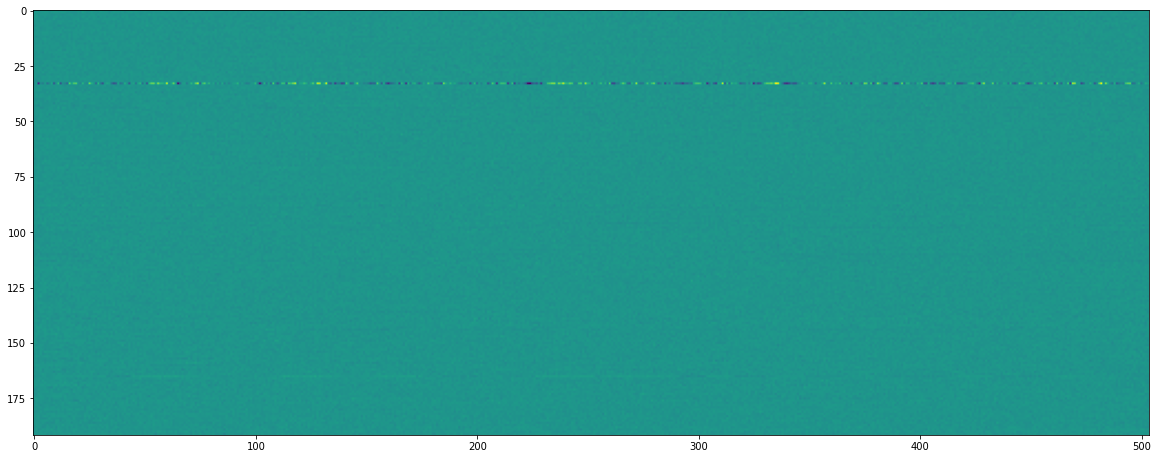

In [33]:
plt.figure(figsize=(20, 20))
plt.imshow(z_p.squeeze(0).numpy())

In [34]:
z_p

tensor([[[ 0.3704,  0.1595, -1.1093,  ..., -0.9923,  1.3184,  0.4270],
         [ 0.0915,  0.7233,  0.6482,  ...,  1.1078,  0.2622,  0.2500],
         [ 0.2599,  1.4145, -0.5801,  ...,  0.2351,  0.1482, -0.0738],
         ...,
         [-1.3078,  2.9909, -1.8322,  ...,  2.4624,  0.3127,  0.7985],
         [-1.3890,  0.7614, -0.4381,  ...,  0.4621,  0.7481, -0.7064],
         [ 1.1638,  0.0895,  0.1819,  ...,  1.0366,  0.0224,  1.9769]]])

In [35]:
np.savetxt("zp_emotion002.csv", z_p.squeeze(0).numpy(), delimiter=',')

## 4 学習したモデルを読み込む

CONFIG_PATH に学習に利用したjsonファイルを`「./configs/****.json」`のように指定し、  
NET_PATHに学習したモデルを`「./configs/xxxx/G_*****.pth」`のように指定してください。


CONFIG_PATH = "./configs/train_config_zundamon.json"  
CONFIG_PATH = "./configs/train_config.json"



特に設定をいじっていない場合、CONFIG_PATHはどちらかになると思います。

In [ ]:
CONFIG_PATH = "./configs/train_config_zundamon.json"
NET_PATH = "./logs/20220516_1/G_2000.pth"

指定したファイルをもとにモデルの読み込みを行います。

In [14]:
hps = utils.get_hparams_from_file(CONFIG_PATH)

In [17]:
net_g = SynthesizerTrn(
    len(symbols),
    hps.data.filter_length // 2 + 1,
    hps.train.segment_size // hps.data.hop_length,
    n_speakers=hps.data.n_speakers,
    **hps.model)
_ = net_g.eval()

_ = utils.load_checkpoint(NET_PATH, net_g, None)

## 5 学習したモデルでTTSを行う

TEXTに**ひらがな**で文章を入力してください。

In [54]:
TEXT = "おはよう、しょくん。わたしはてんのうずあいるだ。これはおんせいごうせいのてすとだ。どうだ？すごいだろう。"

TTS_Speaker_IDにTTSを実行する話者IDを代入してください。  
(filelists/xxxx_Correspondence.txtに話者Idと対応した話者の対応が出力されています！)

In [57]:
#TTS_Speaker_ID = 100
TTS_Speaker_ID = 14

実際にTTSを行います。

イントネーションがおかしくなることが多々ありますが、VC的には問題なので気にしなくて大丈夫です。

初回のみpyopenjtalk周りのダウンロードが始まるので、少し時間がかかりますが仕様です。

In [58]:
text = TEXT
stn_tst = get_text(mozi2phone(text), hps)

with torch.no_grad():
    x_tst = stn_tst.unsqueeze(0)
    x_tst_lengths = torch.LongTensor([stn_tst.size(0)])
    sid = torch.LongTensor([TTS_Speaker_ID])
    audio = net_g.infer(x_tst, x_tst_lengths, sid=sid, noise_scale=.400, noise_scale_w=0.8, length_scale=1)[0][0,0].data.cpu().float().numpy()
ipd.display(ipd.Audio(audio, rate=hps.data.sampling_rate))

## 6 学習したモデルで非リアルタイムVCを行う

非リアルタイムのVCを行います。

ソース話者のIDとその話者の音声ファイルのパス、変換ターゲットの話者のIDを指定してください。

In [72]:
SOURCE_WAVFILE = "dataset/textful/00_myvoice/wav/emotion002.wav"
SOURCE_SPEAKER_ID = 107
TARGET_ID = 100

実際にVCを行います。

ここでの性能が悪い場合、学習不足か他に問題があります。

In [73]:
with torch.no_grad():
    dataset = TextAudioSpeakerLoader(hps.data.validation_files_notext, hps.data)
    data = dataset.get_audio_text_speaker_pair([SOURCE_WAVFILE, SOURCE_SPEAKER_ID, "a"])
    data = TextAudioSpeakerCollate()([data])
    x, x_lengths, spec, spec_lengths, y, y_lengths, sid_src = [x for x in data]
    sid_tgt1 = torch.LongTensor([TARGET_ID])
    audio1 = net_g.voice_conversion(spec, spec_lengths, sid_src=sid_src, sid_tgt=sid_tgt1)[0][0,0].data.cpu().float().numpy()
print("Original SID: %d" % sid_src.item())
ipd.display(ipd.Audio(y[0].cpu().numpy(), rate=hps.data.sampling_rate))
print("Converted SID: %d" % sid_tgt1.item())
ipd.display(ipd.Audio(audio1, rate=hps.data.sampling_rate))

0it [00:00, ?it/s]


(SynthesizerTrn::voice_conversion) y.shape:torch.Size([1, 257, 504]), y_lengths:tensor([504])
(SynthesizerTrn::voice_conversion) z.shape:torch.Size([1, 192, 504])
(SynthesizerTrn::voice_conversion) z_p.shape:torch.Size([1, 192, 504])
(SynthesizerTrn::voice_conversion) z_hat.shape:torch.Size([1, 192, 504])
(SynthesizerTrn::voice_conversion) o_hat.shape:torch.Size([1, 1, 64512])
Original SID: 107


Converted SID: 100


Data Augmentationのテスト

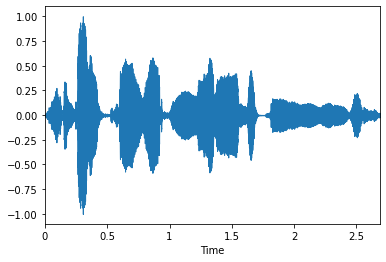

In [11]:
import librosa
import librosa.display

sampling_rate = 24000
speech, rate = librosa.load(SOURCE_WAVFILE, sr=sampling_rate)
librosa.display.waveplot(speech, sr=rate)
plt.show()
ipd.display(ipd.Audio(speech, rate=rate))

In [ ]:
speech.size

64512

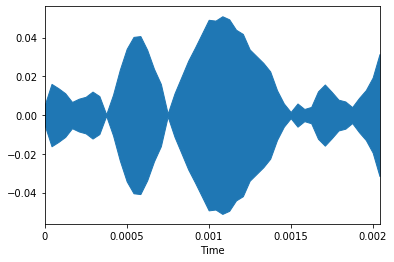

In [ ]:
librosa.display.waveplot(speech[5950:6000], sr=rate)
plt.show()

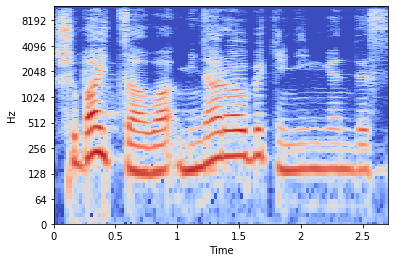

In [ ]:
D = librosa.stft(speech)
S, phase = librosa.magphase(D)
Sdb = librosa.amplitude_to_db(S)
librosa.display.specshow(Sdb, sr=rate, x_axis="time", y_axis="log")

In [ ]:
Sdb

array([[-32.574028, -37.023148, -28.518705, ..., -10.566306, -23.848503,
        -21.61306 ],
       [-33.724   , -32.772114, -29.480347, ..., -13.32152 , -16.2156  ,
        -15.933321],
       [-34.5086  , -37.023148, -33.01266 , ..., -16.428072, -17.956146,
        -11.225523],
       ...,
       [-37.023148, -37.023148, -37.023148, ..., -37.023148, -37.023148,
        -34.283157],
       [-37.023148, -37.023148, -37.023148, ..., -37.023148, -37.023148,
        -34.4737  ],
       [-37.023148, -37.023148, -37.023148, ..., -37.023148, -37.023148,
        -34.68461 ]], dtype=float32)

In [ ]:
# torchaudio でspectrogram
# https://github.com/zassou65535/VITS/blob/main/vits_voice_converter.py

#スペクトログラムの計算時に何サンプル単位でSTFTを行うか
filter_length = 1024
#スペクトログラムの計算時に適用する窓の大きさ
win_length = 1024
#ホップ数　何サンプルずらしながらSTFTを行うか
hop_length = 256

wav, _ = torchaudio.load(SOURCE_WAVFILE)
#wav.shape
pad_size = int((filter_length - hop_length)/2)
wav_padded = torch.nn.functional.pad(wav, (pad_size, pad_size), mode="reflect")
spec = torchaudio.functional.spectrogram(
    waveform=wav_padded, pad=0, window=torch.hann_window(win_length), n_fft=filter_length, hop_length=hop_length, win_length=win_length, power=2, normalized=False, center=False
)

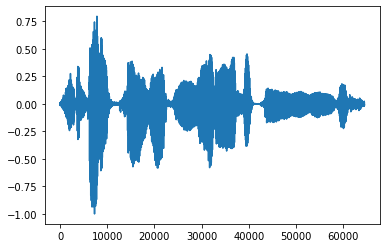

In [ ]:
plt.figure()
plt.plot(wav.t().numpy())

In [ ]:
y = wav.t()

#torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[wnsize_dtype_device],
#                      center=center, pad_mode='reflect', normalized=False, onesided=True)
#    "sampling_rate": 24000,
#    "filter_length": 512,
#    "hop_length": 128,
#    "win_length": 512,
#    "n_mel_channels": 80,
#    "mel_fmin": 0.0,
#    "mel_fmax": null,
n_fft =         512 # hps.data.filter_length
num_mels =      80  # hps.data.n_mel_channels
sampling_rate = 24000 # hps.data.sampling_rate
hop_size =      128 # hps.data.hop_length
win_size =      512 # hps.data.win_length
fmin =          0.0 # hps.data.mel_fmin
fmax =          None # hps.data.mel_fmax
center =        False

hann_window = {}
dtype_device = str(y.dtype) + '_' + str(y.device)
fmax_dtype_device = str(fmax) + '_' + dtype_device
wnsize_dtype_device = str(win_size) + '_' + dtype_device
hann_window[wnsize_dtype_device] = torch.hann_window(win_size).to(dtype=y.dtype, device=y.device)
torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[wnsize_dtype_device],
                      center=center, pad_mode='reflect', normalized=False, onesided=True)

RuntimeError: ignored